In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
plt.style.use("default")

In [2]:
# read our fresh preprocessed data from previous notebook

data = pd.read_csv("preprocessed_features.csv",index_col="Unnamed: 0")

In [3]:
X = data.drop("classes", axis = 1)
y = data.classes

 We now have to split our data into training and testing sets. 
 The train_test_split will take our 1000 data and split it into 2
 To do so, it will randomly select data and split in 2
 We will use a ratio of 800 and 200 for training and testing respectively
 We have to stratify the split, our data is well separated in 100 of each class
So we need to keep that proportion when we split.

In [4]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.8, stratify=y)

In [5]:
# We can now try to fit a simple logistic regression model
# We first build our model with the LogisticRegression object
# We use a the default liblinear solver because our data is not so big

logreg = LogisticRegression(solver="liblinear")

In [6]:
# Now we fit our training data to the model

logreg.fit(X_tr,y_tr);

/Users/jasonola/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


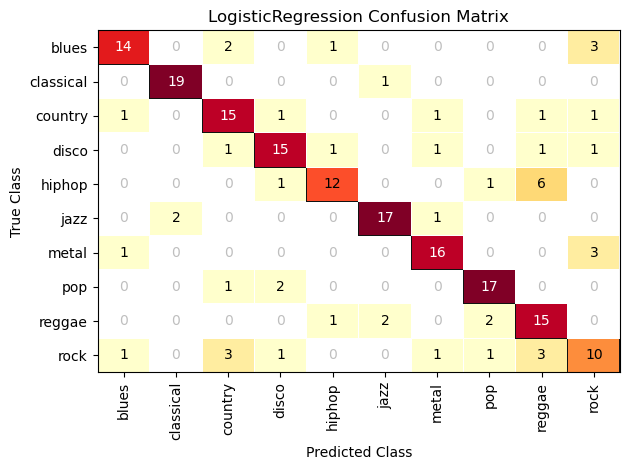

In [7]:
# And finally we can see the results in a confusion matrix 

logreg_cm = ConfusionMatrix(logreg)
logreg_cm.score(X_te,y_te)
logreg_cm.show();

 We see the number of times a genre was correctly labeled in the diagonal. 
 If we sum each line it adds up to 20, which are the number of test data we have for each 
 (remember we split our data in 800 for train and 200 for test so 200 test/10 classes is 20)
 Other values not on diagonal means they are misclassified. Here we have 18 well classified blues 
 and there 2 missclassified in jazz... but is that really misclassification ? 
 We also see that rock has poor results, but again, it was often misclassified as country
 same goes for country the other way around. We can argue that rock sounds like country.
 We also see that rock was never misclassified as hiphop or classical which are very different genres.
 Based on this we can assume our model did a good job of classifying our genres.

/Users/jasonola/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


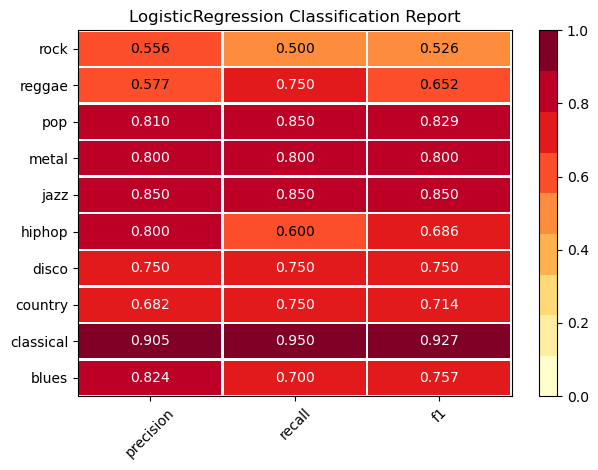

In [8]:
# And in a classification report

logreg_report = ClassificationReport(logreg)
logreg_report.score(X_te,y_te)
logreg_report.show();

Here is a classification report where we see precision, recall and f1 score.  
Precision is the proportion of true positive with true positive and false positive  
Recall is the proportion of true positive with the relevant instances (true positive and false negative)  
f1 score is the harmonic mean of precision and recall.

We see that we already have good results on most genres, however the model struggles with rock as it has been only been classified right half the time and mixed up with almost all other genres, especially country

In [9]:
# Now we can do some grid search to try and get better hyperparameter values, so first we have to make our grid of values
# the grid is a dictionnary of hyperparameters we want to tweak and a list of values for each hyperparameter
# For the logistic regression there is only one hyperparameter to change, the C.
# Be carefull for other models there might be more you should check the documentation of the model.

grid = {
    'logreg__C': np.logspace(-4, 4, num=9)
}

In [10]:
# Here we build a pipeline that we can use in our gridsearch later, it's a usefull thing to use because we can pipe a lot
# of machine learning operations together. I will show an example later where we could add a PCA model.
# We could also, instead of doing scaling operation in prep notebook, do it in this pipeline before the model. 

logreg_pipe = Pipeline([
    ("logreg",LogisticRegression(solver="liblinear"))
])

In [11]:
# we instanciate our grid search object, the gridsearch also does a cross-validation where it extracts an independent
# subset of data from the training data : validation data. We then use this as intermediate "test" data in multiple 
# iterations (folds). This technique is used to prevent overfitting 
# Overfitting is a phenomenon that occurs when you train your data too much on the same data. 
# It then learns "by heart" the data and it has very good score. But if you give it new data it
# might not do so well. An analogy would be like a football team that wins a lot of matches in a place and the team
# learns how to play against all the team in the same championship. But when they play somewhere else with new
# teams they are lost because other team might have other strategies..

logreg_grid_search = GridSearchCV(logreg_pipe,grid)

In [12]:
# We fit

logreg_grid_search.fit(X_tr,y_tr)

GridSearchCV(estimator=Pipeline(steps=[('logreg',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'logreg__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])})

In [13]:
# We display the results

cv_results = pd.DataFrame(logreg_grid_search.cv_results_)
cols = ['mean_test_score', 'param_logreg__C']
cv_results[cols].sort_values('mean_test_score', ascending=False)

,mean_test_score,param_logreg__C
3,0.68625,0.1
4,0.66625,1
2,0.65625,0.01
5,0.64875,10
6,0.63250,100
7,0.61750,1000
8,0.60750,10000
1,0.53875,0.001
0,0.43375,0.0001


We see that the best scores are around 0.1 and 1 so we could do a finer grid search to try and get better results

In [14]:
# We do a finer grid with values between 0.1 and 1

fine_grid = {
    'logreg__C': np.arange(0.1,1.1,0.1)
}

In [15]:
logreg_grid_search_fine = GridSearchCV(logreg_pipe,fine_grid,cv=5)

In [16]:
logreg_grid_search_fine.fit(X_tr,y_tr)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('logreg',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'logreg__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})

In [17]:
cv_results_fine = pd.DataFrame(logreg_grid_search_fine.cv_results_)
cv_results_fine[cols].sort_values('mean_test_score', ascending=False)

,mean_test_score,param_logreg__C
0,0.68625,0.1
1,0.67875,0.2
2,0.67375,0.3
6,0.67375,0.7
4,0.67000,0.5
7,0.67000,0.8
3,0.66875,0.4
5,0.66875,0.6
8,0.66875,0.9
9,0.66625,1


We see that the results are a bit better !

/Users/jasonola/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


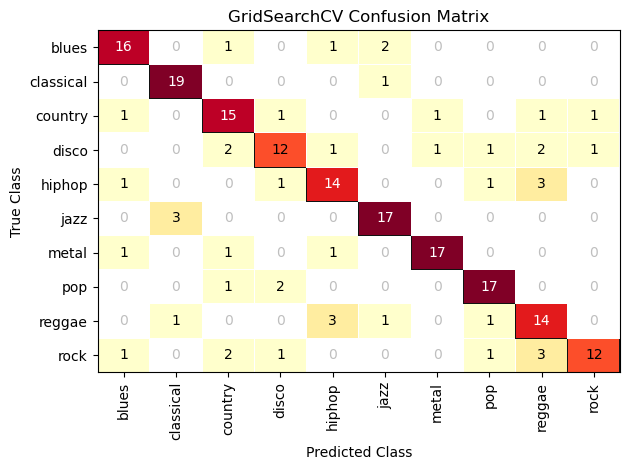

In [18]:
logreg_fine_cm = ConfusionMatrix(logreg_grid_search_fine)
logreg_fine_cm.score(X_te,y_te)
logreg_fine_cm.show();

Even though the results are better, we dont see much improvement on the confusion matrices.

/Users/jasonola/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


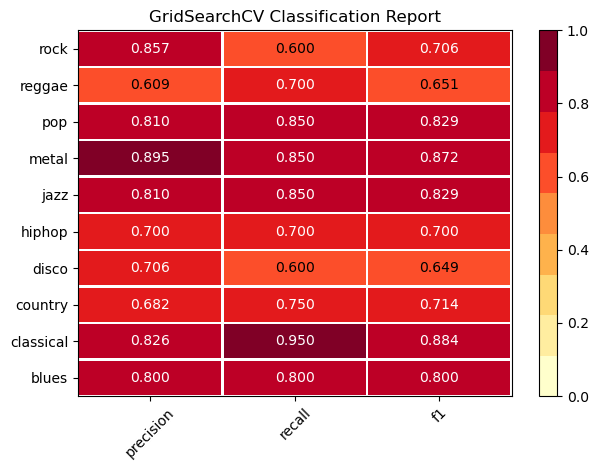

In [19]:
gridlogreg_report = ClassificationReport(logreg_grid_search_fine)
gridlogreg_report.score(X_te,y_te)
gridlogreg_report.show();

In [20]:
# Let's now add that PCA step into our pipeline

logreg_pipe_pca = Pipeline([
    ("pca", PCA(n_components=57)),
    ("logreg",LogisticRegression(solver="liblinear"))
])

In [21]:
logreg_pca_grid_search_fine = GridSearchCV(logreg_pipe_pca,fine_grid)

In [22]:
logreg_pca_grid_search_fine.fit(X_tr,y_tr);

In [23]:
cv_results_pca = pd.DataFrame(logreg_pca_grid_search_fine.cv_results_)
cv_results_pca[cols].sort_values('mean_test_score', ascending=False)

,mean_test_score,param_logreg__C
0,0.64000,0.1
1,0.63625,0.2
2,0.63000,0.3
3,0.62750,0.4
4,0.62500,0.5
5,0.61875,0.6
6,0.61875,0.7
7,0.61875,0.8
8,0.61875,0.9
9,0.61250,1


The results are a bit worse with pca, which is normal as we are discarding some features, PCA could be something to consider if we need speed efficiency.

/Users/jasonola/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


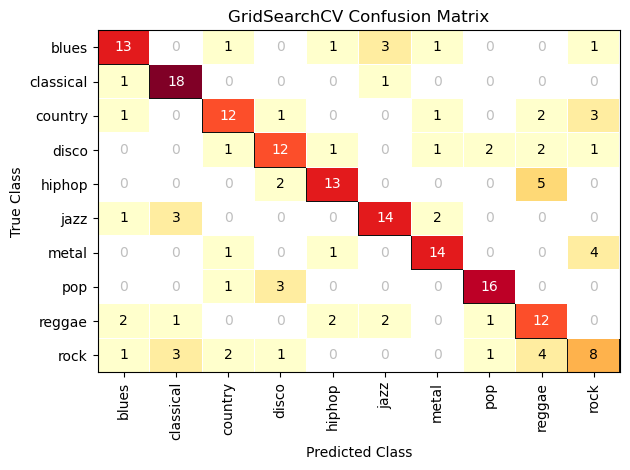

In [24]:
logreg_pca_cm = ConfusionMatrix(logreg_pca_grid_search_fine)
logreg_pca_cm.score(X_te,y_te)
logreg_pca_cm.show();

In [25]:
pickle.dump(logreg_grid_search_fine, open("model_test.sav","wb"))